**Trabalho de Deep Learning**



In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns

print(tf.__version__)

2.3.0


In [3]:
link = "https://raw.githubusercontent.com/rmicheldev/datasets/main/MoviesOnStreamingPlatforms_updated.csv"

# Carrega o arquivo do github
rawDf = pd.read_csv(link)

In [4]:
rawDf.head(10)

,Unnamed: 0,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0
5,5,6,Spider-Man: Into the Spider-Verse,2018,7+,8.4,97%,1,0,0,0,0,"Bob Persichetti,Peter Ramsey,Rodney Rothman","Animation,Action,Adventure,Family,Sci-Fi",United States,"English,Spanish",117.0
6,6,7,The Pianist,2002,18+,8.5,95%,1,0,1,0,0,Roman Polanski,"Biography,Drama,Music,War","United Kingdom,France,Poland,Germany","English,German,Russian",150.0
7,7,8,Django Unchained,2012,18+,8.4,87%,1,0,0,0,0,Quentin Tarantino,"Drama,Western",United States,"English,German,French,Italian",165.0
8,8,9,Raiders of the Lost Ark,1981,7+,8.4,95%,1,0,0,0,0,Steven Spielberg,"Action,Adventure",United States,"English,German,Hebrew,Spanish,Arabic,Nepali",115.0
9,9,10,Inglourious Basterds,2009,18+,8.3,89%,1,0,0,0,0,Quentin Tarantino,"Adventure,Drama,War","Germany,United States","English,German,French,Italian",153.0


In [5]:
#Mostra os tipos de dados
rawDf.dtypes

Unnamed: 0           int64
ID                   int64
Title               object
Year                 int64
Age                 object
IMDb               float64
Rotten Tomatoes     object
Netflix              int64
Hulu                 int64
Prime Video          int64
Disney+              int64
Type                 int64
Directors           object
Genres              object
Country             object
Language            object
Runtime            float64
dtype: object

* Unnamed: 0           int64   Numerical
* ID                   int64   Numerical 
* Title               object   ????
* Year                 int64   Numerical 
* Age                 object   Categorical
* IMDb               float64   Numerical
* Rotten Tomatoes     object   Numerical
* Netflix              int64   Categorical
* Hulu                 int64   Categorical
* Prime Video          int64   Categorical
* Disney+              int64   Categorical
* Type                 int64   Categorical
* Directors           object   Categorical
* Genres              object   Categorical 
* Country             object   Categorical
* Language            object   Categorical 
* Runtime            float64   Numerical

In [6]:
# Remove a primeira coluna (indice 0) que não possui valor e a coluna Type e a nota no Rotten Tomatoes 
explDf = rawDf.drop(rawDf.columns[[0]], axis=1).drop(['Type','Rotten Tomatoes'], axis=1)
explDf.head(10)

,ID,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,1,Inception,2010,13+,8.8,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,18+,8.7,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,3,Avengers: Infinity War,2018,13+,8.5,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,4,Back to the Future,1985,7+,8.5,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0
5,6,Spider-Man: Into the Spider-Verse,2018,7+,8.4,1,0,0,0,"Bob Persichetti,Peter Ramsey,Rodney Rothman","Animation,Action,Adventure,Family,Sci-Fi",United States,"English,Spanish",117.0
6,7,The Pianist,2002,18+,8.5,1,0,1,0,Roman Polanski,"Biography,Drama,Music,War","United Kingdom,France,Poland,Germany","English,German,Russian",150.0
7,8,Django Unchained,2012,18+,8.4,1,0,0,0,Quentin Tarantino,"Drama,Western",United States,"English,German,French,Italian",165.0
8,9,Raiders of the Lost Ark,1981,7+,8.4,1,0,0,0,Steven Spielberg,"Action,Adventure",United States,"English,German,Hebrew,Spanish,Arabic,Nepali",115.0
9,10,Inglourious Basterds,2009,18+,8.3,1,0,0,0,Quentin Tarantino,"Adventure,Drama,War","Germany,United States","English,German,French,Italian",153.0


In [7]:
# Dropa todas as linhas que tem colunas faltando informação 
explDf = explDf.dropna()
display(explDf)

,ID,Title,Year,Age,IMDb,Netflix,Hulu,Prime Video,Disney+,Directors,Genres,Country,Language,Runtime
0,1,Inception,2010,13+,8.8,1,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,18+,8.7,1,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,3,Avengers: Infinity War,2018,13+,8.5,1,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,4,Back to the Future,1985,7+,8.5,1,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,1,0,1,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16726,16727,Richie Rich's Christmas Wish,1998,all,4.1,0,0,0,1,John Murlowski,"Comedy,Family",United States,English,84.0
16727,16728,The Jungle Book: Mowgli's Story,1998,all,4.2,0,0,0,1,Nick Marck,"Adventure,Family",United States,English,77.0
16737,16738,The Bears and I,1974,all,6.2,0,0,0,1,Bernard McEveety,"Drama,Family",United States,English,89.0
16738,16739,Whispers: An Elephant's Tale,2000,all,5.0,0,0,0,1,Dereck Joubert,"Adventure,Family",United States,English,72.0


In [8]:
#renomeando colunas
colsRen = {'ID':'id',
        'Title':'title',
        'Year':'year',
        'Age':'age',
        'IMDb':'imdb',        
        'Netflix':'netflix',
        'Hulu':'hulu',
        'Prime Video':'prime',
        'Disney+':'disney',        
        'Directors':'directors',
        'Genres':'genres',
        'Country':'country',
        'Language':'language',
        'Runtime':'runtime'
        }


explDf = explDf.rename(columns = colsRen, inplace = False)
explDf.dtypes

id             int64
title         object
year           int64
age           object
imdb         float64
netflix        int64
hulu           int64
prime          int64
disney         int64
directors     object
genres        object
country       object
language      object
runtime      float64
dtype: object

In [9]:
#Verificando quais valores que IMDb pode assumir
notasImdb = np.sort(explDf['imdb'].unique())
display(notasImdb)

array([1. , 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1])

In [10]:
#Dividindo os dados para treino e teste (validação)
testeDf = explDf.sample(frac=0.2, random_state=42)
treinoDf = explDf.drop(testeDf.index)

print("%d amostras para treino e %d para teste" % (len(treinoDf),len(testeDf)))

5637 amostras para treino e 1409 para teste


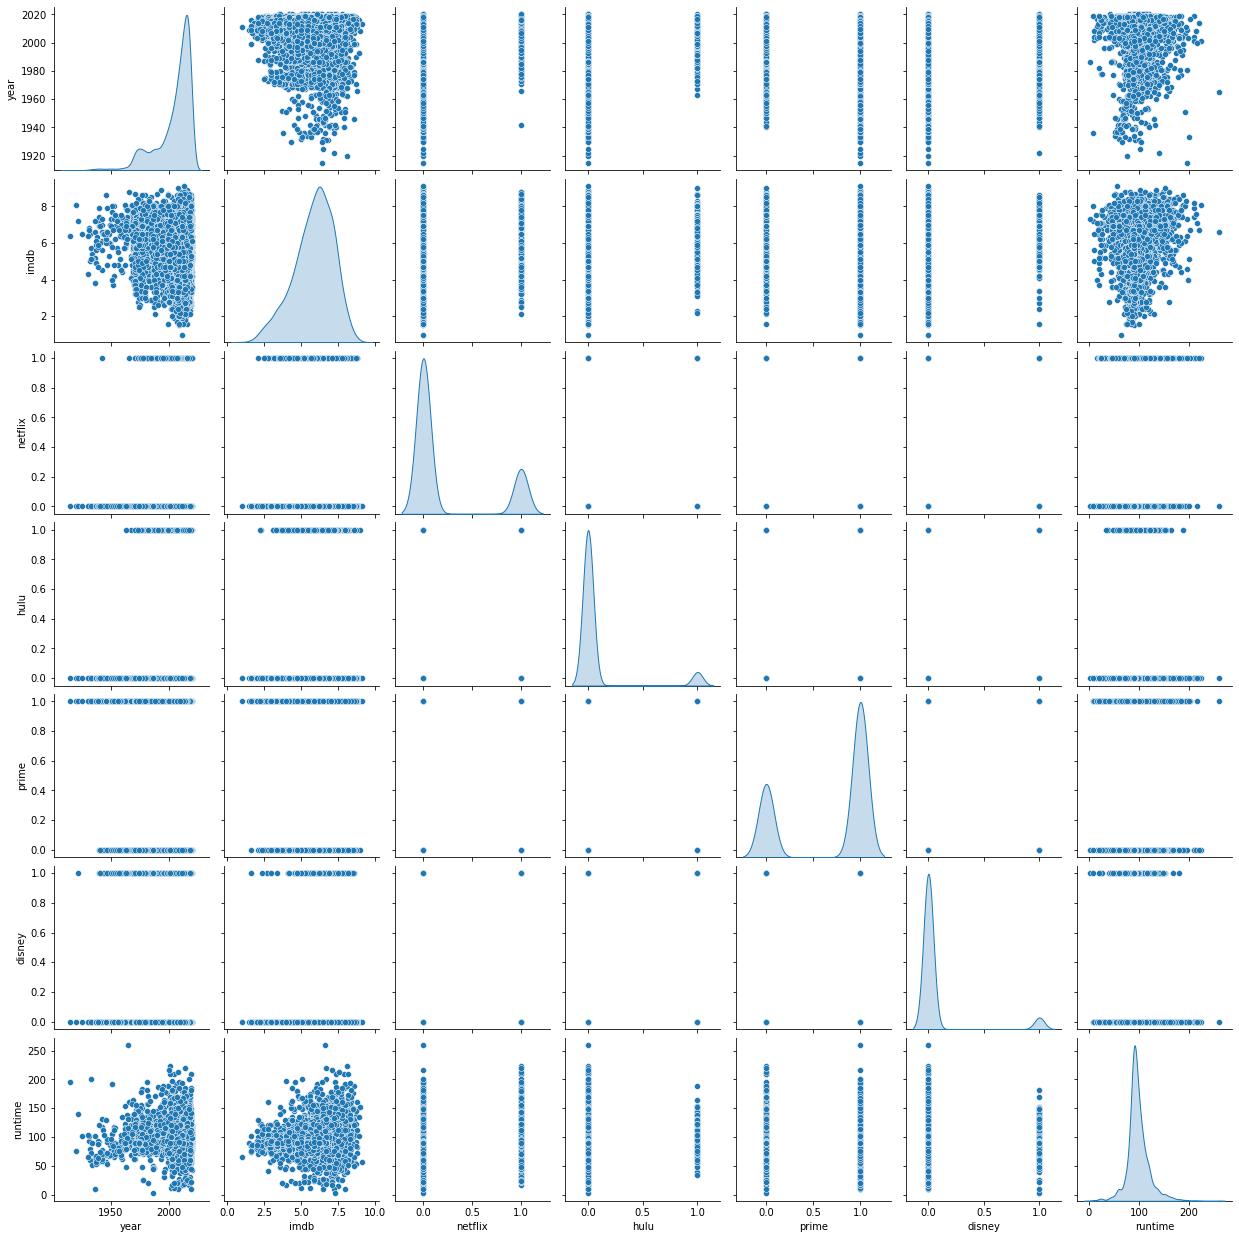

In [11]:
sns.pairplot(treinoDf[["year","age","imdb","netflix","hulu","prime","disney","directors","genres","country","language","runtime"]], diag_kind="kde")

In [12]:
def dataframe_to_dataset(dataframe,labels):
    dataframe = dataframe.copy()    
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

In [13]:
testeDf = testeDf.drop(['id','title'],axis=1)

In [14]:
lblTreino = treinoDf.pop("imdb")
lblTeste = testeDf.pop("imdb")
treinoDs = dataframe_to_dataset(treinoDf,lblTreino)
testeDs = dataframe_to_dataset(testeDf,lblTeste)

In [15]:
for x, y in treinoDs.take(1):
    print("Input:", x)
    print("Target:", y)

Input: {'id': <tf.Tensor: shape=(), dtype=int64, numpy=3907>, 'title': <tf.Tensor: shape=(), dtype=string, numpy=b'Unlocked'>, 'year': <tf.Tensor: shape=(), dtype=int64, numpy=2017>, 'age': <tf.Tensor: shape=(), dtype=string, numpy=b'18+'>, 'netflix': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hulu': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'prime': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'disney': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'directors': <tf.Tensor: shape=(), dtype=string, numpy=b'Michael Apted'>, 'genres': <tf.Tensor: shape=(), dtype=string, numpy=b'Action,Drama,Mystery,Thriller'>, 'country': <tf.Tensor: shape=(), dtype=string, numpy=b'Czech Republic,Switzerland,United Kingdom,United States,France'>, 'language': <tf.Tensor: shape=(), dtype=string, numpy=b'English,Arabic,German'>, 'runtime': <tf.Tensor: shape=(), dtype=float64, numpy=98.0>}
Target: tf.Tensor(6.2, shape=(), dtype=float64)


In [16]:
treinoDs = treinoDs.batch(32)
testeDs = testeDs.batch(32)

In [17]:
# código retirado de https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature


In [18]:
shp = (1,)

year =  keras.Input(shape=shp,name="year", dtype="int64") 
netflix =  keras.Input(shape=shp,name="netflix", dtype="int64")
hulu =  keras.Input(shape=shp,name="hulu", dtype="int64") 
prime =  keras.Input(shape=shp,name="prime", dtype="int64")
disney =  keras.Input(shape=shp,name="disney", dtype="int64")

runtime = keras.Input(shape=shp,name="runtime")

age = keras.Input(shape=shp,name="age", dtype="string")
directors = keras.Input(shape=shp,name="directors", dtype="string")
genres = keras.Input(shape=shp,name="genres", dtype="string")
country = keras.Input(shape=shp,name="country", dtype="string")
language = keras.Input(shape=shp,name="language", dtype="string")

In [19]:
all_inputs = [
year,
netflix,
hulu,
prime,
disney,
runtime,
age,
directors,
genres,
country,
language
]

In [20]:
year_encoded = encode_integer_categorical_feature(year, "year", treinoDs)
netflix_encoded = encode_integer_categorical_feature(netflix, "netflix", treinoDs)
hulu_encoded = encode_integer_categorical_feature(hulu, "hulu", treinoDs)
prime_encoded = encode_integer_categorical_feature(prime, "prime", treinoDs)
disney_encoded = encode_integer_categorical_feature(disney, "disney", treinoDs)

runtime_encoded = encode_numerical_feature(runtime, "runtime", treinoDs)

age_encoded = encode_string_categorical_feature(age, "age", treinoDs)
directors_encoded = encode_string_categorical_feature(directors, "directors", treinoDs)
genres_encoded = encode_string_categorical_feature(genres, "genres", treinoDs)
country_encoded = encode_string_categorical_feature(country, "country", treinoDs)
language_encoded = encode_string_categorical_feature(language, "language", treinoDs)

In [21]:
all_features = layers.concatenate(
    [
     year_encoded,
     netflix_encoded,
     hulu_encoded,
     prime_encoded,
     disney_encoded,

     runtime_encoded,

     age_encoded,
     directors_encoded,
     genres_encoded,
     country_encoded,
     language_encoded   
    ]
)

In [22]:
(all_features)

<tf.Tensor 'concatenate/concat:0' shape=(None, 8611) dtype=float32>

In [23]:
#x = layers.Dense(32, activation="relu")(all_features)
#x = layers.Dropout(0.5)(x)
#output = layers.Dense(1, activation="sigmoid")(x)
#model = keras.Model(all_inputs, output)
#model.compile("adam", "binary_crossentropy", metrics=["accuracy"])


In [32]:
x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "mean_squared_error", metrics=["accuracy","mae","mse"])


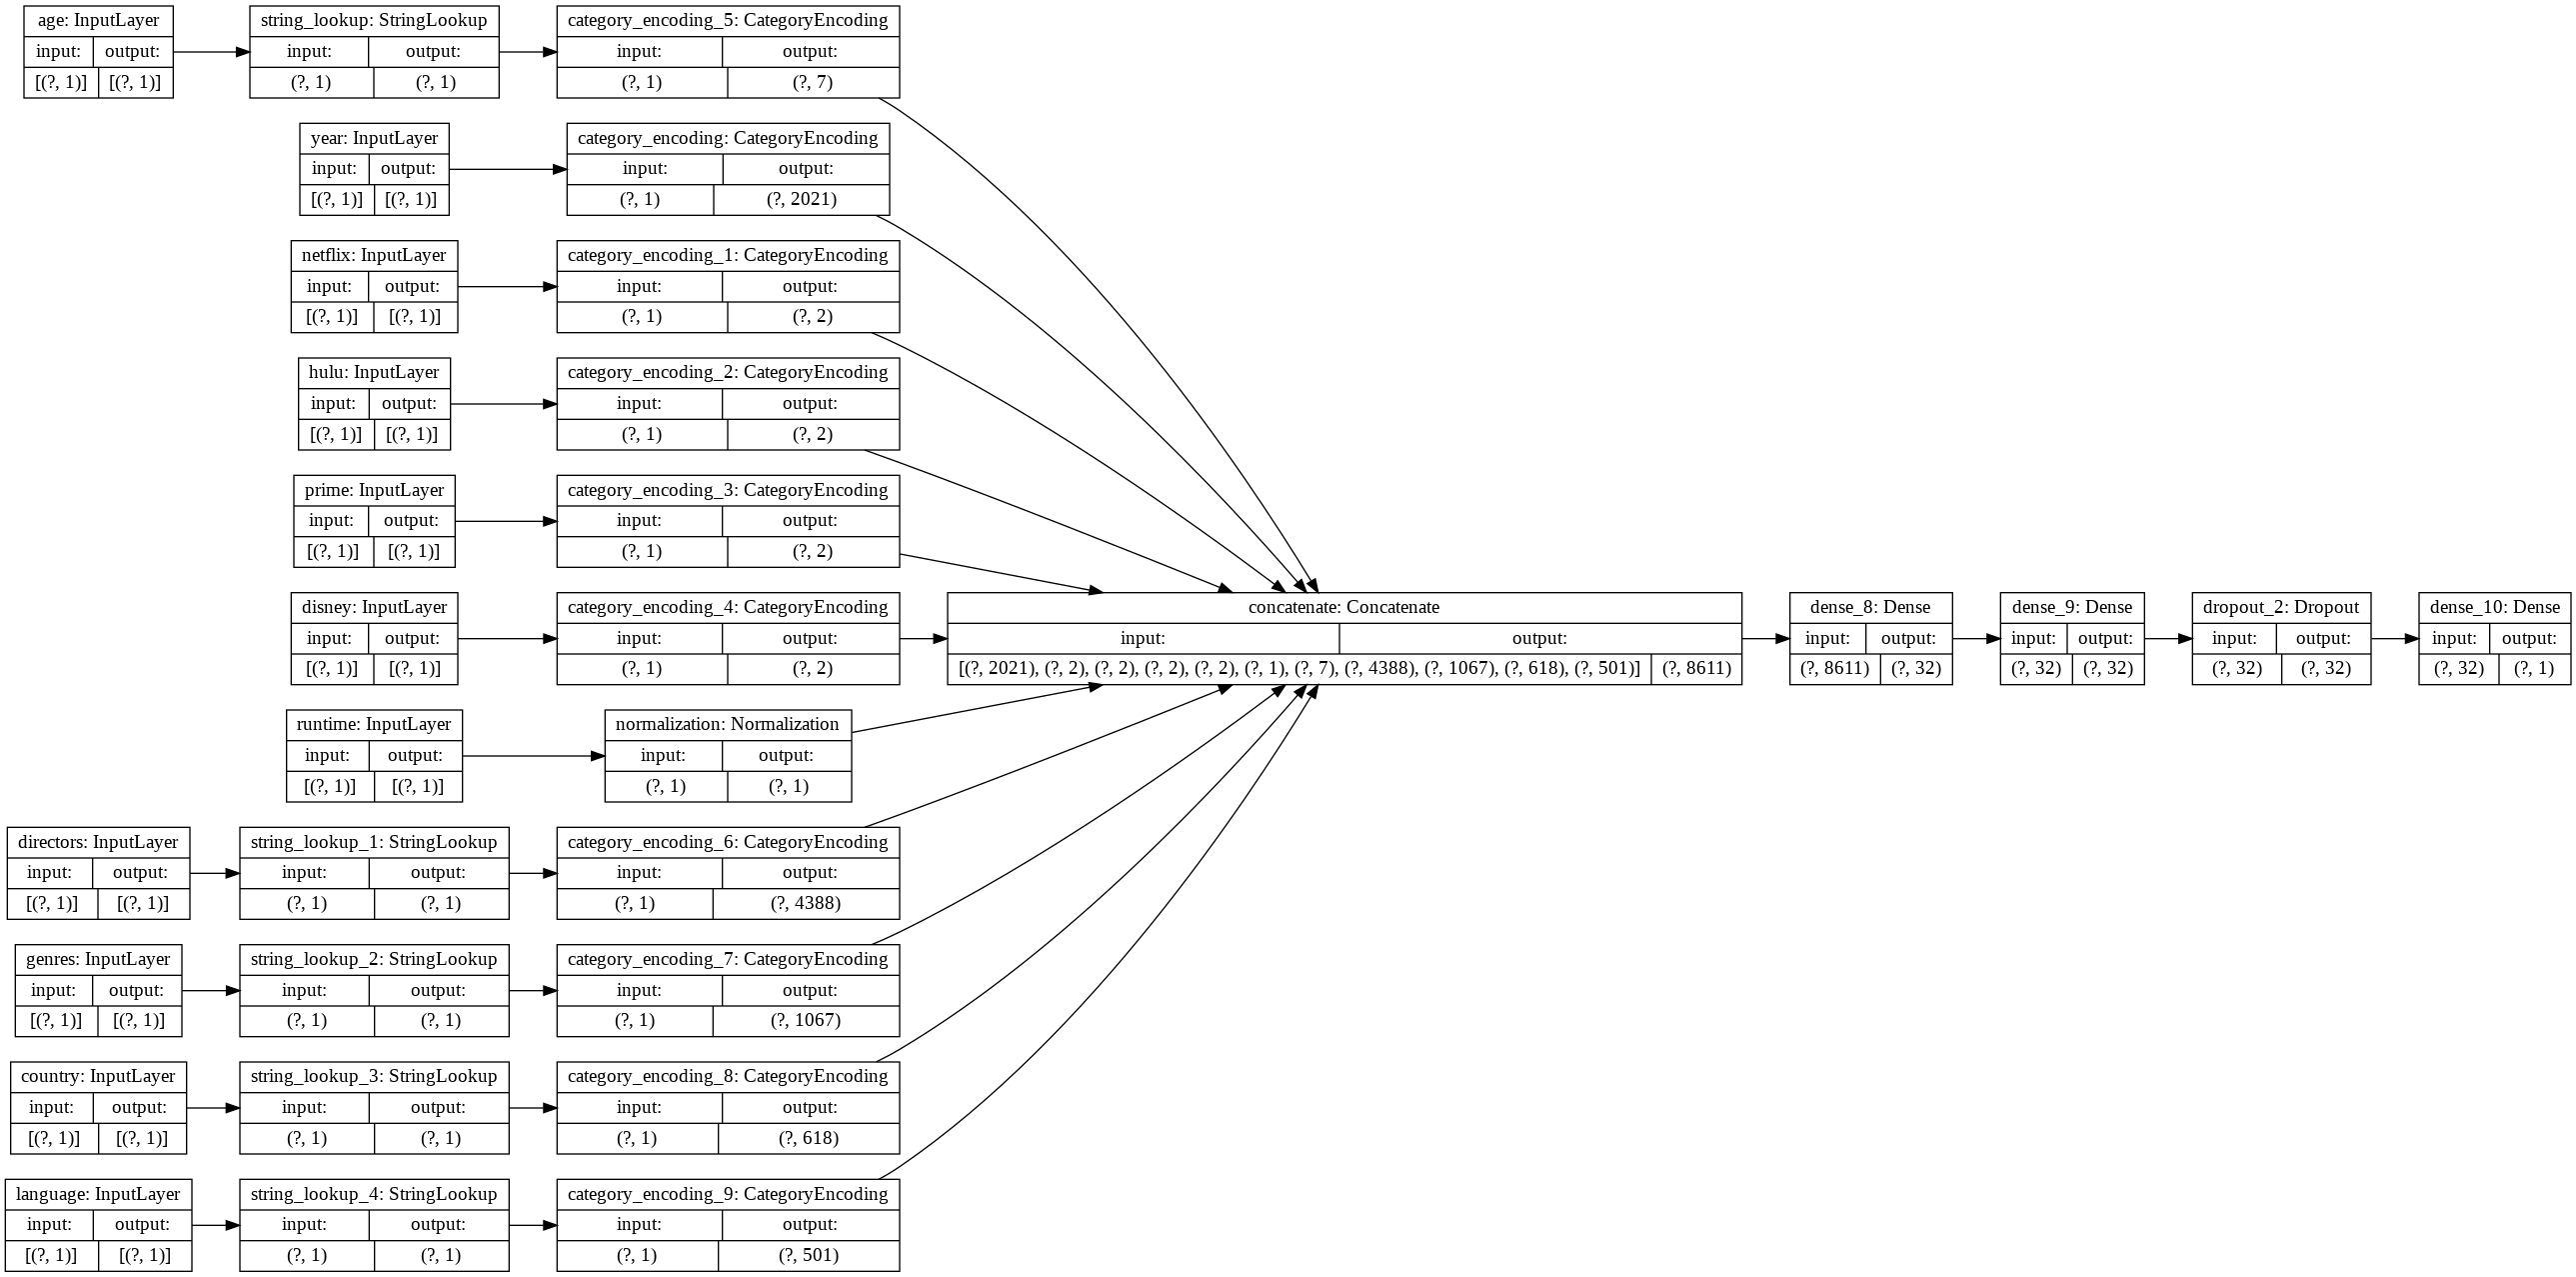

In [33]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [34]:
history=model.fit(treinoDs, epochs=10, validation_data=testeDs)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['id', 'title'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


177/177 [==============================] - 1s 8ms/step - loss: 26.3545 - accuracy: 1.7740e-04 - mae: 4.9533 - mse: 26.3545 - val_loss: 25.4314 - val_accuracy: 0.0000e+00 - val_mae: 4.8707 - val_mse: 25.4314
Epoch 2/10
177/177 [==============================] - 1s 6ms/step - loss: 25.2569 - accuracy: 1.7740e-04 - mae: 4.8437 - mse: 25.2569 - val_loss: 25.4256 - val_accuracy: 0.0000e+00 - val_mae: 4.8701 - val_mse: 25.4256
Epoch 3/10
177/177 [==============================] - 1s 6ms/step - loss: 25.2441 - accuracy: 1.7740e-04 - mae: 4.8424 - mse: 25.2441 - val_loss: 25.4253 - val_accuracy: 0.0000e+00 - val_mae: 4.8701 - val_mse: 25.4253
Epoch 4/10
177/177 [==============================] - 1s 6ms/step - loss: 25.2416 - accuracy: 1.7740e-04 - mae: 4.8422 - mse: 25.2416 - val_loss: 25.4253 - val_accuracy: 0.0000e+00 - val_mae: 4.8701 - val_mse: 25.4253
Epoch 5/10
177/177 [==============================] - 1s 7ms/step - loss: 25.2408 - accuracy: 1.7740e-04 - mae: 4.8421 - mse: 25.2408 - val

In [36]:
#display(history.history)
hist = pd.DataFrame(history.history)
display(hist)
# Trinenando a rede neural
 

,loss,accuracy,mae,mse,val_loss,val_accuracy,val_mae,val_mse
0,26.354530,0.000177,4.953275,26.354530,25.431379,0.0,4.870730,25.431379
1,25.256893,0.000177,4.843698,25.256893,25.425571,0.0,4.870147,25.425571
2,25.244101,0.000177,4.842423,25.244101,25.425348,0.0,4.870124,25.425348
3,25.241554,0.000177,4.842165,25.241554,25.425318,0.0,4.870121,25.425318
4,25.240786,0.000177,4.842087,25.240786,25.425306,0.0,4.870121,25.425306
5,25.240795,0.000177,4.842078,25.240795,25.425310,0.0,4.870121,25.425310
6,25.240778,0.000177,4.842096,25.240778,25.425310,0.0,4.870121,25.425310
7,25.240000,0.000177,4.841998,25.240000,25.425304,0.0,4.870121,25.425304
8,25.239592,0.000177,4.841967,25.239592,25.425312,0.0,4.870120,25.425312
9,25.239450,0.000177,4.841955,25.239450,25.425304,0.0,4.870120,25.425304


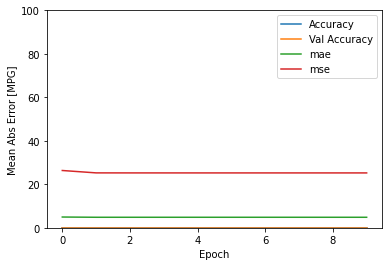

In [48]:
  def plot_history(history):
      hist = pd.DataFrame(history.history)
      hist['epoch'] = history.epoch

      plt.figure()
      plt.xlabel('Epoch')
      plt.ylabel('Mean Abs Error [MPG]')
      plt.plot(hist['epoch'],hist['accuracy'],label='Accuracy')
      plt.plot(hist['epoch'],hist['val_accuracy'],label = 'Val Accuracy')
      plt.plot(hist['epoch'],hist['mae'],label = 'mae')
      plt.plot(hist['epoch'],hist['mse'],label = 'mse')
      plt.ylim([0,100])
      plt.legend()


plot_history(history)

  # plt.figure()
  # plt.xlabel

In [49]:
# Testando com o filme Inception
sampleRec = {
    "year": 2010,
    "age": "13+",
    "netflix": 1,
    "hulu": 0,
    "prime": 0,
    "disney": 0,
    "directors": "Christopher Nolan",
    "genres": "Action,Adventure,Sci-Fi,Thriller",
    "country": "United States,United Kingdom",
    "language": "English,Japanese,French",
    "runtime": 148.0
}


#Testando com o filme Furie 
sampleNotRec = {
    "year": 2019,
    "age": "18+",
    "netflix": 1,
    "hulu": 0,
    "prime": 0,
    "disney": 0,
    "directors": "David Ayer",
    "genres": "Action,Drama,War",
    "country": "United States,China,United Kingdom",
    "language": "English,German",
    "runtime": 134.0
}

In [50]:
input_dictRec = {name: tf.convert_to_tensor([value]) for name, value in sampleRec.items()}
predictionsRec = model.predict(input_dictRec)
#predictionsRec = model.predict(testeDs)

In [52]:
#print(
#    "Este filme tem %.1f porcento de probabilidade "
    #"de ser recomendado como um bom filme." % (100 * predictionsRec[0][0],)
#)

print(predictionsRec)

[[1.]]


In [ ]:
input_dictNotRec = {name: tf.convert_to_tensor([value]) for name, value in sampleNotRec.items()}
predictionsNotRec = model.predict(input_dictNotRec)

In [ ]:
print(
    "Este filme tem %.1f porcento de probabilidade "
    "de ser recomendado como um bom filme." % (100 * predictionsNotRec[0][0],)
)